# Stateful graph
Requires a well defined schema for managing the state of the graph.

[StateGraph class](https://langchain-ai.github.io/langgraph/reference/graphs/)
[State schema](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#define-input-and-output-schemas)

### State
A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

* The input schema is well defined
* By default the input & output schema are the same
* You may define an output schema explicitly. Overall state is a combination of input & output schema 

### Node
* A function : receives the state as argument
* The node must return a dictionary which may be partial set of keys or the entire state

### Edge
* Connects the nodes
* Decides the direction of the flow i.e., next node to be executed

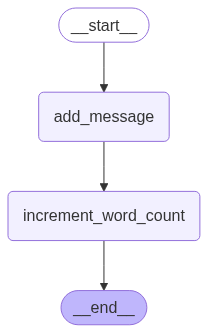

{'messages': ['This is a dummy message when total_words = 0'],
 'total_words': 44}

In [5]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END

# Provide the schema in the form of keys & their types
class StateBasic(TypedDict):
    messages: List[str]
    total_words: int
    
# Node
# Updates & returns the entire state
def add_message(state: StateBasic) -> dict:
    message = f"This is a dummy message when total words = {state["total_words"]}"

    messages = state["messages"] + [message]

    return { "messages": messages}

# Node
# Returns a dict with only the state-keys that are updated
def increment_word_count(state: StateBasic)->dict:
    last_message = state["messages"][-1]
    total_word = state["total_words"]+len(last_message)
    return {"total_words": total_word}

# Create a stateful graph
workflow_stateful = StateGraph(StateBasic)

# Add the nodes
workflow_stateful.add_node("add_message", add_message)
workflow_stateful.add_node("increment_word_count", increment_word_count)

# Add the edges
# START is a special node that receives user input
workflow_stateful.add_edge(START, "add_message")  
workflow_stateful.add_edge("add_message", "increment_word_count")
# END is a special node that returns the state and ends the graph run
workflow_stateful.add_edge("increment_word_count", END)

# Prepares the graph from the node/edge relations
workflow_stateful_compiled = workflow_stateful.compile()

# Visualize the graph
from IPython.display import Image, display
display(Image(workflow_stateful_compiled.get_graph().draw_mermaid_png()))

# Invoke the graph
workflow_stateful_compiled.invoke({"total_words":0, "messages": []})

## **Python Annotated** 
is a type hint introduced in Python 3.9 (available via typing package) that allows you to attach metadata to type annotations. It doesn't affect type checking but provides additional information that can be used by tools and libraries.

```
from typing import Annotated

variable: Annotated[type, metadata1, metadata2, ...]
```

* Preserves the base type - The actual type remains the first argument

* Accepts arbitrary metadata - Any Python object can be used as metadata

* Doesn't affect runtime behavior - Just like other typing hints

* Useful for documentation and tools - Many libraries leverage these annotations

#### **LangGraph** use of Annotated
In LangGraph, when you define a graph State, you can use Annotated to attach update functions to state variables. These functions specify how the state should be modified when new values arrive.

**Key Behavior:**
* Metadata is a function that takes the current value and the new value.

* When the state updates, LangGraph applies this function to merge values.

* If no function is provided, it defaults to replacement (new value overwrites the old one).

#### Reducer functions

A reducer function may be used with Annotated[..] to define how the messages field in the graph state should be updated when multiple nodes modify it.

#### add_message
https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages


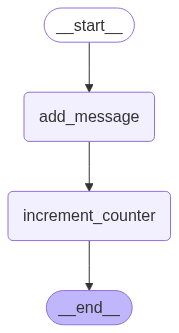

{'messages': ['This is a dummy message when total_words = 0', 'This is a dummy message when total_words = 44'], 'total_words': 89}


In [4]:
from typing import TypedDict, List, Annotated
import operator
from langgraph.graph import StateGraph, START, END

# Reducer function that appends a message to the list
def append_to_list(current: List[str], 
                   new: List[str])->List[str]:
    return current + new
    
# Provide the schema in the form of keys & their types
class StateAnnotated(TypedDict):
    # Applies reducer function to the updated value
    messages: Annotated[List[str], append_to_list]
    
    # Applies the add function to the updated value
    total_words: Annotated[int, operator.add]
    
# Node
# Updates & returns the entire state
def add_message_annotated(state: StateAnnotated)->StateAnnotated:
    message = f"This is a dummy message when total_words = {state["total_words"]}"

    # NO NEED TO DO THIS - Let LangGraph apply the reducer function
    # state["messages"] = state["messages"] + [message]
    
    return {"messages": [message]}

# Node
# Returns a dict with only the state-keys that are updated
def increment_word_count_annotated(state: StateAnnotated)->dict:
    last_message = state["messages"][-1]

    # NO NEED TO DO THIS - Let LangGraph apply the reducer
    # total_word = state["total_words"]+len(last_message)
    
    return {"total_words": len(last_message)}

# Create a stateful graph
workflow_stateful_annotated = StateGraph(StateAnnotated)

# Add the nodes
workflow_stateful_annotated.add_node("add_message", add_message_annotated)
workflow_stateful_annotated.add_node("increment_counter", increment_word_count_annotated)

# Add the edges
# START is a special node that receives user input
workflow_stateful_annotated.add_edge(START, "add_message")  
workflow_stateful_annotated.add_edge("add_message", "increment_counter")
# END is a special node that returns the state and ends the graph run
workflow_stateful_annotated.add_edge("increment_counter", END)

# Prepares the graph from the node/edge relations
workflow_stateful_annotated_compiled = workflow_stateful_annotated.compile()

# Visualize the graph
from IPython.display import Image, display
display(Image(workflow_stateful_annotated_compiled.get_graph().draw_mermaid_png()))

# Invoke the graph twice

#1. Call#1 with initial state
response = workflow_stateful_annotated_compiled.invoke({"total_words":0, "messages": []})

#2. Pass the response from first call as a request in second call
response = workflow_stateful_annotated_compiled.invoke(response)

print(response)
